In [2]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [3]:
terms = ['I', 'like', 'apples', 'oranges', 'pears']
vectors = [nlp(term).vector.tolist() for term in terms]

In [4]:
import numpy as np
import pandas as pd

In [5]:
pd.Series(vectors[terms.index('apples')]).rename('apples')

0     2.955669
1     3.195763
2     1.915051
3     1.288756
4    -0.205873
        ...   
91   -0.072856
92    2.420412
93   -0.790477
94    0.096754
95   -0.888562
Name: apples, Length: 96, dtype: float64

In [6]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

cm = sns.light_palette('Gray', as_cmap=True)
pd.DataFrame(
    cosine_similarity(vectors),
    index=terms, columns=terms
).round(3).style.background_gradient(cmap=cm)

,I,like,apples,oranges,pears
I,1.000000,0.296000,0.007000,0.043000,0.079000
like,0.296000,1.000000,0.107000,0.168000,0.223000
apples,0.007000,0.107000,1.000000,0.736000,0.808000
oranges,0.043000,0.168000,0.736000,1.000000,0.757000
pears,0.079000,0.223000,0.808000,0.757000,1.000000


In [9]:
import os
import zipfile
from io import BytesIO
import requests

data_dir = f'{os.getcwd()}/data'

if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip'
response = requests.get(url)

with zipfile.ZipFile(file=BytesIO(response.content), mode='r') as compressed_file:
    compressed_file.extractall(data_dir)

In [10]:
df_list = []

for csv_file in ['imdb_labelled.txt', 'yelp_labelled.txt',
                'amazon_cells_labelled.txt']:
    csv_file_with_path = f'{data_dir}/sentiment labelled sentences/{csv_file}'
    temp_df = pd.read_csv(csv_file_with_path,
                         sep='\t', header=0,
                         names=['text', 'sentiment'])
    df_list.append(temp_df)
    df = pd.concat(df_list)

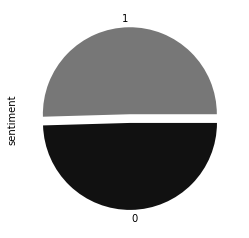

In [11]:
explode = [0.05, 0.05]
colors = ['#777777', '#111111']
df['sentiment'].value_counts().plot(
kind='pie', colors=colors, explode=explode
)

In [13]:
pd.options.display.max_colwidth = 90
df[['text', 'sentiment']].sample(5, random_state=2)

,text,sentiment
2,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1
317,I want my money back.,0
733,We have tried 2 units and they both failed within 2 months.. Pros,0
458,We loved the place.,1
672,"It is well made, easy to access the phone and has a handy, detachable belt clip.",1


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_fscore_support

df_train, df_test = train_test_split(df, test_size=0.4,
random_state=42)
y_train = df_train['sentiment']
y_test = df_test['sentiment']

vec = CountVectorizer(ngram_range=(1,3), min_df=3,
strip_accents='ascii')
x_train = vec.fit_transform(df_train['text'])
x_test = vec.transform(df_test['text'])

clf = MultinomialNB(fit_prior=True)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)